In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../geometry') 
from pyMesh import hcubeMesh, visualize2D, plotBC, plotMesh,setAxisLabel

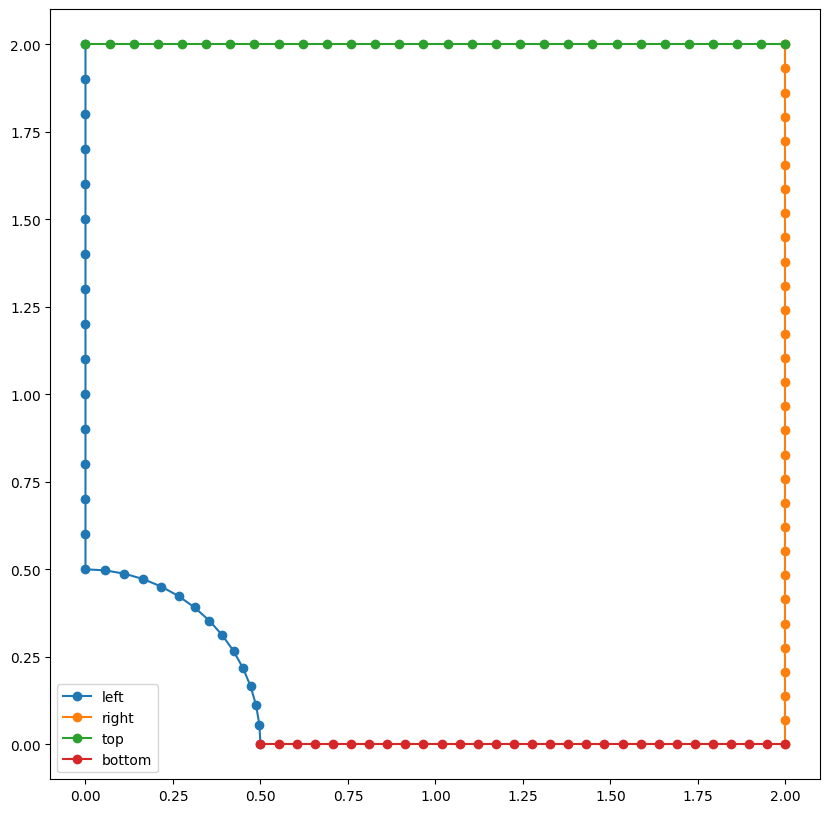

In [5]:
#define geometry

L = 2.0
R = 0.5
O = [0.0, 0.0]

n_point = 30

theta = 0

leftX_1 = R*np.cos(np.linspace(theta, np.pi/2+theta, int(n_point/2))) + O[0]
leftX_2 = np.zeros(int(n_point/2)+1)
leftX = np.concatenate((leftX_1, leftX_2[1:]))

leftY_1 = R*np.sin(np.linspace(theta, np.pi/2+theta, int(n_point/2))) + O[1]
leftY_2 = np.linspace(R, L, int(n_point/2)+1)
leftY = np.concatenate((leftY_1, leftY_2[1:]))

rightX = np.ones(n_point)*L
# rightY = leftY
rightY = np.linspace(0, L, n_point)

upX = np.linspace(0, L, n_point)
upY = np.ones(n_point)*L

lowX = np.linspace(R,L,n_point)
lowY = np.zeros(n_point)


fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.plot(leftX, leftY, marker='o', label='left')
plt.plot(rightX, rightY, marker='o', label='right')
plt.plot(upX, upY, marker='o', label='top')
plt.plot(lowX, lowY, marker='o', label='bottom')

ax.set_aspect('equal')
plt.legend()



In [6]:
h=0.01

myMesh=hcubeMesh(leftX,leftY,rightX,rightY,
	             lowX,lowY,upX,upY,h,False,False,
	             tolMesh=1e-10,tolJoint=1e-2)


====>Check bc nodes!
====>BC nodes pass!
The mesh generation reaches covergence!


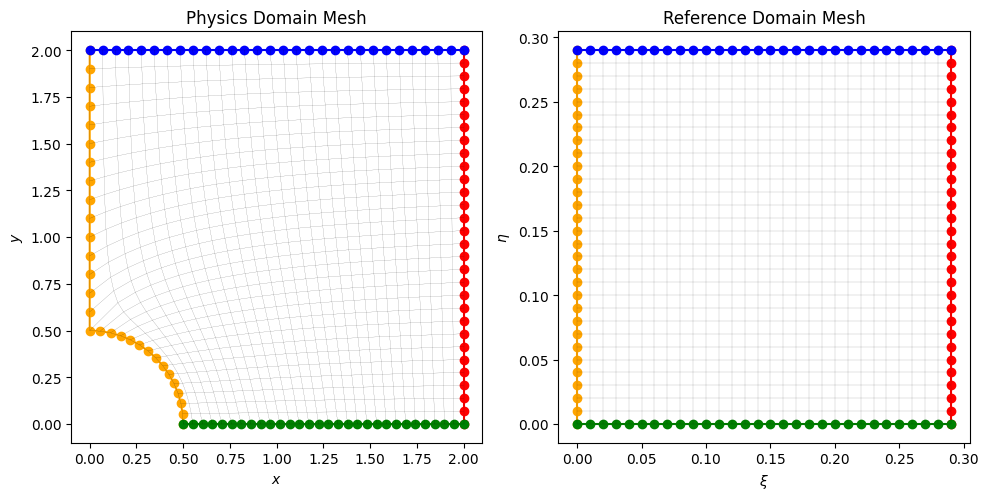

In [7]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
plotBC(ax[0],myMesh.x,myMesh.y)
plotMesh(ax[0],myMesh.x,myMesh.y)
setAxisLabel(ax[0],'p')
ax[0].set_aspect('equal')
ax[0].set_title('Physics Domain Mesh')

plotBC(ax[1],myMesh.xi,myMesh.eta)
plotMesh(ax[1],myMesh.xi,myMesh.eta)
setAxisLabel(ax[1],'r')
ax[1].set_aspect('equal')
ax[1].set_title('Reference Domain Mesh')
fig.tight_layout()

In [8]:
#save the mesh
ny=len(upX); nx=len(leftX)
data_path = f"plate_hole_quarter_{ny}x{nx}.txt"
np.savetxt(data_path, np.hstack((myMesh.x.reshape(-1, 1), myMesh.y.reshape(-1, 1))), delimiter=' ', fmt='%1.16f')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


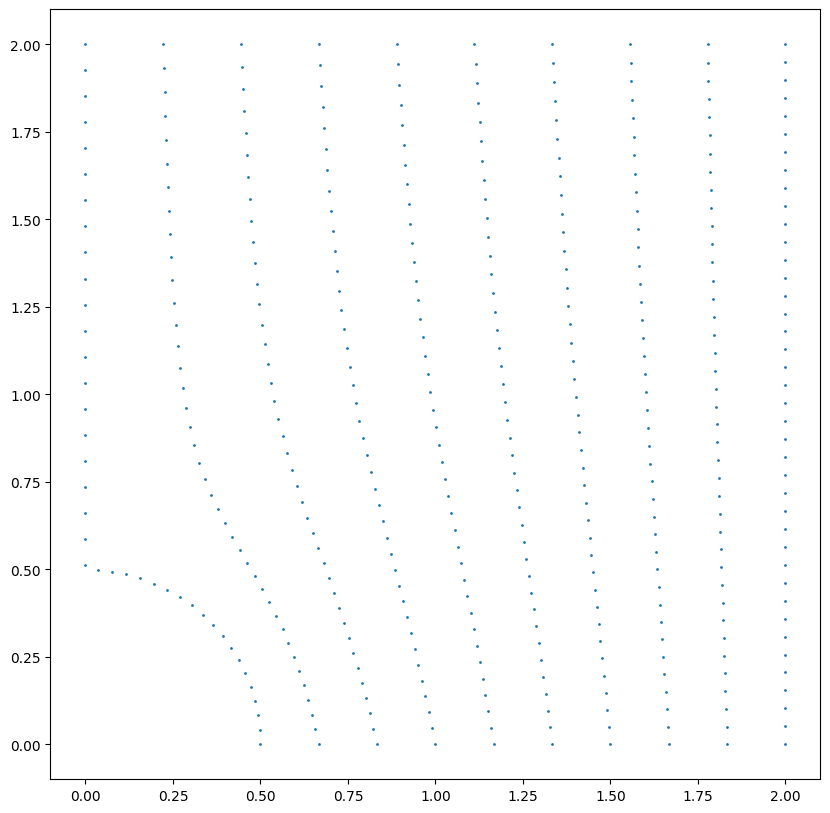

In [10]:
import jax
import jax.numpy as jnp

# Load geometry mapping
nx=30
ny=30
Xp = np.loadtxt(f"plate_hole_quarter_{nx}x{ny}.txt")

# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def coordMap(x):
    x_pos = x[:, 0]*(nx-1)
    y_pos = x[:, 1]*(ny-1)

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1)
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1)

    return jnp.stack((x_mapped, y_mapped), axis=1)


x_plot = np.linspace(0, 1, 10)
y_plot = np.linspace(0, 1, 40)
X_plot, Y_plot = np.meshgrid(x_plot, y_plot)
X_plot, Y_plot = X_plot.flatten(), Y_plot.flatten()
X_mapped, Y_mapped = coordMap(jax.numpy.stack((X_plot, Y_plot), axis=1)).T

fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.scatter(X_mapped, Y_mapped, s=1)
# plt.xlim(0, x_max)
# plt.ylim(0, y_max)
ax.set_aspect('equal')

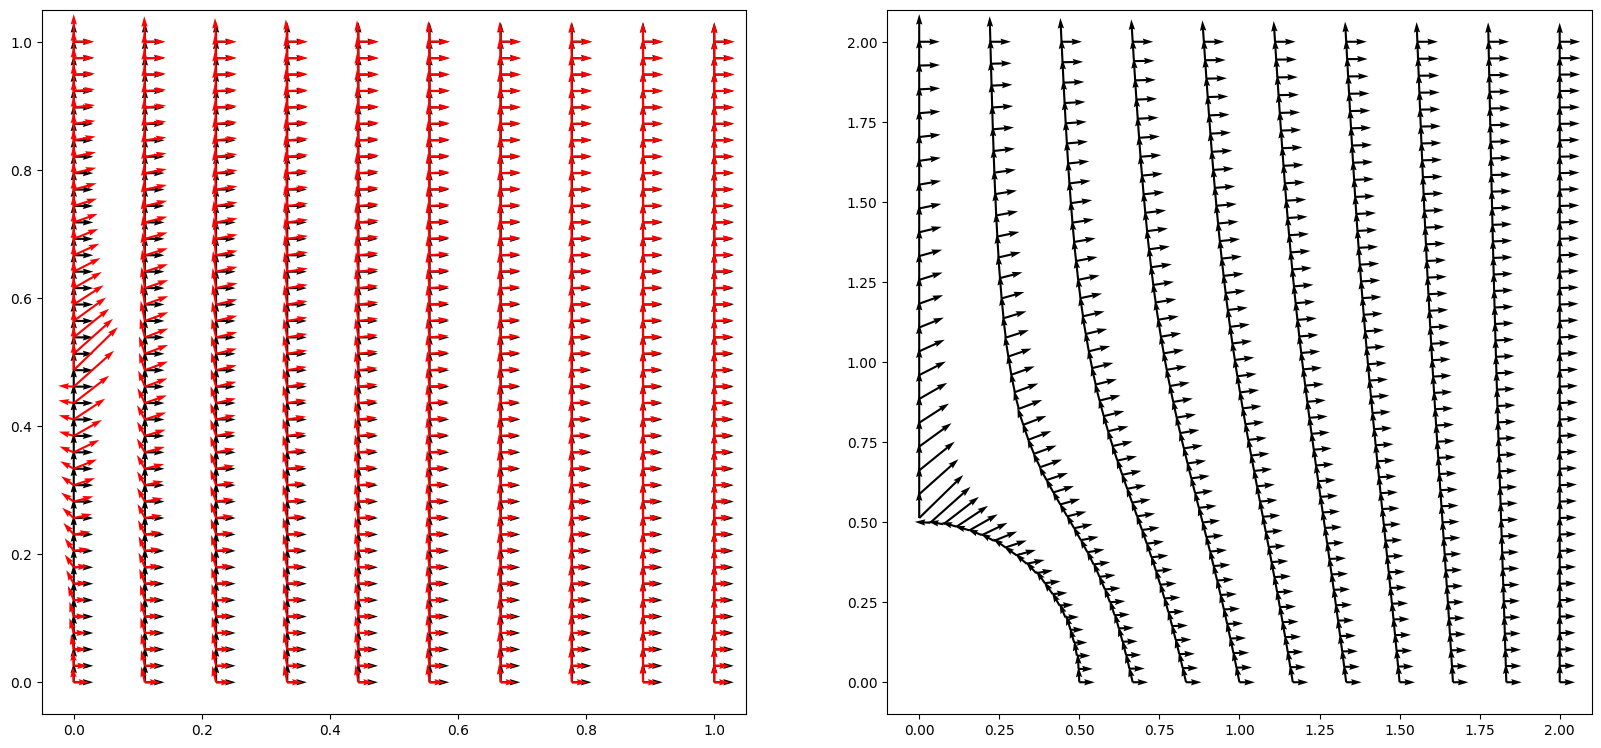

In [11]:
def coordMap(x, padding=1e-6):
    x_pos = x[0]*(nx-1)*(1-2*padding) + padding
    y_pos = x[1]*(ny-1)*(1-2*padding) + padding

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1, mode='nearest')
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1, mode='nearest')

    return jnp.stack((x_mapped, y_mapped), axis=0)

def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    return J @ tens 

vec1 = jnp.ones(X_mapped.shape)
vec0 = jnp.zeros(X_mapped.shape)

U_1 = jnp.stack((vec1, vec0), axis=1)
U_2 = jnp.stack((vec0, vec1), axis=1)

U1_mapped = jax.vmap(tensMap)(U_1, jnp.stack((X_plot, Y_plot), axis=1)).squeeze()
U2_mapped = jax.vmap(tensMap)(U_2, jnp.stack((X_plot, Y_plot), axis=1)).squeeze()

fig, ax = plt.subplots(1, 2,figsize=(20,10))
ax[0].quiver(X_plot, Y_plot, vec1, vec0)
ax[0].quiver(X_plot, Y_plot, vec0, vec1)

ax[0].quiver(X_plot, Y_plot, U1_mapped[:, 0], U1_mapped[:, 1], color='r')
ax[0].quiver(X_plot, Y_plot, U2_mapped[:, 0], U2_mapped[:, 1], color='r')
ax[0].set_aspect('equal')
ax[1].quiver(X_mapped, Y_mapped, U1_mapped[:, 0], U1_mapped[:, 1])
ax[1].quiver(X_mapped, Y_mapped, U2_mapped[:, 0], U2_mapped[:, 1])
ax[1].set_aspect('equal')